# Toxic comments classification challenge

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

## Data exploration

In [3]:
train_df = pd.read_csv('C:/Users/lilia/OneDrive/Documents/S2 ENSAE/NLP/Project/train.csv')

In [4]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
train_df.shape

(159571, 8)

In [6]:
train_df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [7]:
train_df.dtypes

id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object

In [9]:
train_df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,159571,159571,80f1a5f07d1399b4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
comment_text,159571,159571,Jian Battista Calvi also referred to in the ar...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
toxic,159571,NaN,NaN,NaN,0.0958445,0.294379,0,0,0,0,1
severe_toxic,159571,NaN,NaN,NaN,0.00999555,0.0994771,0,0,0,0,1
obscene,159571,NaN,NaN,NaN,0.0529482,0.223931,0,0,0,0,1
threat,159571,NaN,NaN,NaN,0.00299553,0.0546496,0,0,0,0,1
insult,159571,NaN,NaN,NaN,0.0493636,0.216627,0,0,0,0,1
identity_hate,159571,NaN,NaN,NaN,0.00880486,0.0934205,0,0,0,0,1


In [10]:
train_df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

## Data visualization

In [45]:
types = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
#targets = train_df[types].values

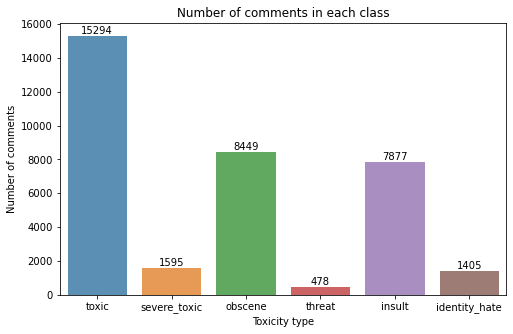

In [48]:
val_counts = train_df[types].sum()

plt.figure(figsize=(8,5))
ax = sns.barplot(x=val_counts.index, y=val_counts.values, alpha=0.8)

plt.title("Number of comments in each class")
plt.xlabel("Toxicity type")
plt.ylabel("Number of comments")

rects = ax.patches
labels = val_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height+5, label, ha="center", va="bottom")
    
plt.show()

## Data pre-processing

In [11]:
train_df["clean_comments"] = train_df["comment_text"].apply(lambda x: x.lower())

In [23]:
def remove_URL(text):
    return re.sub(r"https?://\S+|www\.\S+", "", text)

def remove_html(text):
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    return re.sub(html, "", text)

def remove_non_ascii(text):
    return re.sub(r'[^\x00-\x7f]',r'', text)

def remove_special_characters(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F' 
        u'\U0001F300-\U0001F5FF'  
        u'\U0001F680-\U0001F6FF'  
        u'\U0001F1E0-\U0001F1FF' 
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punct(text):
    return text.translate(str.maketrans('', '', string.punctuation))

In [15]:
train_df["clean_comments"] = train_df["clean_comments"].apply(lambda x: remove_URL(x))

In [17]:
train_df["clean_comments"] = train_df["clean_comments"].apply(lambda x: remove_html(x))

In [19]:
train_df["clean_comments"] = train_df["clean_comments"].apply(lambda x: remove_non_ascii(x))

In [21]:
train_df["clean_comments"] = train_df["clean_comments"].apply(lambda x: remove_special_characters(x))

In [26]:
train_df["clean_comments"] = train_df["clean_comments"].apply(lambda x: remove_punct(x))

In [28]:
train_df['tokenized_comments'] = train_df['clean_comments'].apply(word_tokenize)

In [31]:
stop = set(stopwords.words('english'))
train_df['tokenized_comments'] = train_df['tokenized_comments'].apply(lambda x: [word for word in x if word not in stop])

In [33]:
def porter_stemmer(text):
    stemmer = nltk.PorterStemmer()
    stems = [stemmer.stem(i) for i in text]
    return stems

In [41]:
#train_df['stemmed_text'] = train_df['tokenized_comments'].apply(lambda x: porter_stemmer(x))